#Librerias

In [1]:
!pip install opencv-python # Instala la librería OpenCV para procesamiento de imágenes
!pip install keras-tuner # Se utiliza para realizar búsqueda automática de hiperparámetros en modelos Keras/TensorFlow.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.0 MB/s eta 0:00:00


In [24]:
# Librerías del sistema y manejo de archivos
import os
import sys
from os import listdir
from os.path import join

# Librerías para uso en Google Colab
from google.colab import drive

# Librerías para procesamiento numérico y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Librerías para procesamiento y lectura de imágenes
import cv2

# Librerías para machine learning
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import keras_tuner as kt

# Librerías para deep learning
import tensorflow as tf
from tensorflow.keras.metrics import Recall, AUC

# Librerías para utilidades adicionales
from tqdm import tqdm  # barra de progreso
import joblib  # para guardar/cargar objetos como modelos o arrays

# Conectar con google drive

In [3]:
# conectar con Google Drive para acceder a archivos desde Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path="/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones" ### ruta del repositorio en drive
os.chdir(path) ### volver la carpeta del repositorio directorio de trabajo
sys.path.append(path) ### agregarla al path, poder leer archivos de funciones propios como paquetes

In [5]:
import _funciones as fn #Llamar el archivo de funciones de este proyecto

# Carga de datos procesados

array([[[201, 175, 174],
        [204, 178, 177],
        [203, 179, 179],
        ...,
        [192, 172, 173],
        [185, 167, 167],
        [ 92,  74,  74]],

       [[199, 173, 172],
        [203, 177, 176],
        [203, 179, 179],
        ...,
        [193, 172, 171],
        [105,  84,  85],
        [161, 139, 141]],

       [[197, 171, 170],
        [205, 179, 178],
        [203, 179, 179],
        ...,
        [169, 145, 143],
        [134, 109, 109],
        [195, 170, 170]],

       ...,

       [[202, 169, 164],
        [203, 170, 165],
        [204, 171, 164],
        ...,
        [191, 165, 166],
        [192, 163, 165],
        [193, 164, 166]],

       [[200, 169, 164],
        [200, 169, 164],
        [201, 171, 163],
        ...,
        [194, 168, 169],
        [191, 165, 166],
        [191, 165, 166]],

       [[199, 168, 163],
        [199, 168, 164],
        [202, 172, 164],
        ...,
        [193, 167, 168],
        [191, 165, 166],
        [191, 165, 169]]], dtype=uint8)
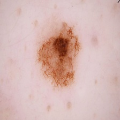

In [6]:
# Cargar los conjuntos de entrenamiento y prueba ya procesados

x_train = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/X_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/X_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/y_test.pkl')

x_train[0] # Muestra la primera imagen del conjunto de entrenamiento

## Preprocesamiento de datos

In [7]:
# Convertir a tipo float para escalar
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [8]:
x_train.max() # Ver valor máximo
x_train.min() # Ver valor mínimo

np.float32(0.0)

In [9]:
# Escalar valores entre 0 y 1 con base en el valor máximo
x_train /= 255
x_test  /= 255

In [10]:
# Verificar dimensiones
x_train.shape
x_test.shape

# Número de variables por imagen
np.prod(x_train[1].shape)

# Ver distribución de clases
np.unique(y_train, return_counts=True)
np.unique(y_test, return_counts=True)

(array([0, 1]), array([285, 375]))

# Modelo de red convolucional simple

In [11]:
# Modelo secuencial, capas apiladas una tras otra
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]), #Capa convolucional
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'), #Capa convolucional
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'), #Capa convolucional
    tf.keras.layers.Dense(1, activation='sigmoid')  # Capa de salida para clasificación binaria (0 o 1) con activación sigmoid
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
#Compilar el modelo con  binary cross-entropy y optimizador de Adam
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

# Entrenar el modelo
cnn_model.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))

# Resumen del modelo
cnn_model.summary()

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - AUC: 0.5705 - loss: 0.9913 - val_AUC: 0.7647 - val_loss: 0.5789
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - AUC: 0.8185 - loss: 0.5137 - val_AUC: 0.8458 - val_loss: 0.6477
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - AUC: 0.8454 - loss: 0.5065 - val_AUC: 0.8637 - val_loss: 0.4549
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - AUC: 0.8885 - loss: 0.4246 - val_AUC: 0.8763 - val_loss: 0.4360
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - AUC: 0.8939 - loss: 0.4100 - val_AUC: 0.8821 - val_loss: 0.4206
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - AUC: 0.9048 - loss: 0.3877 - val_AUC: 0.8754 - val_loss: 0.5745
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - AUC: 0.9026 - loss: 0.4028 - val_AUC: 0.8858 - val_loss: 0.5267
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - AUC: 0.9156 - loss: 0.3717 - val_AUC: 0.8928 - val_loss: 0.3997
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - AUC: 0.9243 - loss: 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,832,549 (18.43 MB)

 Trainable params: 1,610,849 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,221,700 (12.29 MB)

# Modelo convolucional con regularización L2 y Dropout

In [13]:
reg_strength = 0.001  # Fuerza de regularización
dropout_rate = 0.1  # Tasa de dropout

cnn_model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=x_train.shape[1:], kernel_regularizer=tf.keras.regularizers.l2(reg_strength)), #Capa convolucional
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)), #Capa convolucional
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)), #Capa convolucional
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [14]:
# Compilar modelo
cnn_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC', 'accuracy'])

# Entrenar modelo
cnn_model2.fit(x_train, y_train, batch_size=100, epochs=3, validation_data=(x_test, y_test))

Epoch 1/3
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - AUC: 0.4910 - accuracy: 0.5017 - loss: 1.3853 - val_AUC: 0.6828 - val_accuracy: 0.5682 - val_loss: 0.7750
Epoch 2/3
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - AUC: 0.6218 - accuracy: 0.5612 - loss: 0.7588 - val_AUC: 0.7447 - val_accuracy: 0.6667 - val_loss: 0.6967
Epoch 3/3
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - AUC: 0.7410 - accuracy: 0.6704 - loss: 0.6716 - val_AUC: 0.8044 - val_accuracy: 0.6803 - val_loss: 0.6111


# Afinamiento de hiperparametros

## Definición del modelo con hiperparámetros para Keras Tuner

In [25]:
hp = kt.HyperParameters()  # Objeto para definir espacio de búsqueda

def build_model(hp):
    # Hiperparámetros a optimizar
    dropout_rate = hp.Float('DO', 0.05, 0.2, step=0.05) # Tasa de dropout: 5% a 20%
    reg_strength = hp.Float("rs", 0.0001, 0.0005, step=0.0001) # Fuerza de regularización L2
    optimizer = hp.Choice('optimizer', ['adam', 'sgd']) # Optimizador a usar

    hp_units_1 = hp.Int('units_1', 32, 256, step=16) # Numero de neuronas en la capa densa
    hp_activation_1 = hp.Choice('activation_1', ['relu', 'tanh']) # Función de activación

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=x_train.shape[1:], kernel_regularizer=tf.keras.regularizers.l2(reg_strength)), # Capa convolucional
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)), # Capa convolucional
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hp_units_1, activation=hp_activation_1, kernel_regularizer=tf.keras.regularizers.l2(reg_strength)), # Capa convolucional
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid') # Capa de salida para clasificación binaria
    ])

    # Selección del optimizador
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=0.001)
    else:
        opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)


    # Compilación del modelo con función de pérdida y métrica
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=[
            Recall(name='recall'),
            AUC(name='auc')
        ]
    )

    return model # Retorna el modelo construido con los hiperparámetros definidos

### Búsqueda de hiperparámetros con Keras Tuner

In [29]:
# Configurar búsqueda aleatoria de hiperparámetros
tuner = kt.RandomSearch(
    hypermodel=build_model,
    hyperparameters=hp, # Conjunto de hiperparámetros a explorar
    tune_new_entries=True, # Permite agregar nuevos hiperparámetros si aparecen
    objective=kt.Objective("recall", direction="max"), # Maximizar el recall durante la búsqueda
    max_trials=2, # Número de combinaciones distintas a probar
    overwrite=True,
    directory="Salidas",
    project_name="RedConv",
)

# Ejecutar búsqueda de hiperparámetros
tuner.search(x_train, y_train, epochs=3, # Entrena cada modelo por 3 epochs
             validation_data=(x_test, y_test),
             batch_size=100)

# Obtener el mejor modelo encontrado
fc_best_model = tuner.get_best_models(num_models=1)[0] # Toma el mejor modelo según el recall

# Mostrar resumen de la búsqueda
tuner.results_summary() # Imprime tabla con las mejores combinaciones
fc_best_model.summary() # Imprime la arquitectura del mejor modelo

# Evaluar el modelo en el conjunto de prueba
test_loss, test_recall, test_auc = fc_best_model.evaluate(x_test, y_test) # Calcula pérdida y AUC

# Hacer predicciones binarizadas en test (0 o 1)
pred_test = (fc_best_model.predict(x_test) >= 0.50).astype('int') # Umbral de decisión en 0.5

Trial 2 Complete [00h 02m 06s]
recall: 0.7705262899398804

Best recall So Far: 0.7768421173095703
Total elapsed time: 00h 04m 56s
Results summary
Results in Salidas/RedConv
Showing 10 best trials
Objective(name="recall", direction="max")

Trial 0 summary
Hyperparameters:
DO: 0.15000000000000002
rs: 0.0004
optimizer: adam
units_1: 144
activation_1: tanh
Score: 0.7768421173095703

Trial 1 summary
Hyperparameters:
DO: 0.05
rs: 0.0001
optimizer: sgd
units_1: 96
activation_1: relu
Score: 0.7705262899398804


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 59, 59, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 144)            │     3,612,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,618,049 (13.80 MB)

 Trainable params: 3,618,049 (13.80 MB)

 Non-trainable params: 0 (0.00 B)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - auc: 0.7914 - loss: 0.7189 - recall: 0.5045
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step


# Exportar modelo entrenado

In [ ]:
# Solo si se necesita
#fc_best_model.save('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_model.h5')  # Guardar modelo entrenado